<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/TimeSeries6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

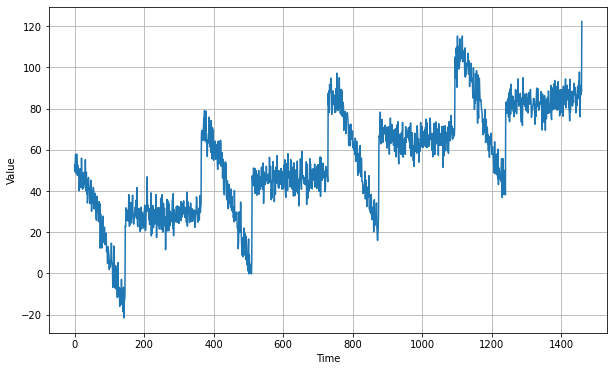

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [6]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)

model = keras.models.Sequential([
      keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
      keras.layers.SimpleRNN(100, return_sequences=True),
      keras.layers.SimpleRNN(100),
      keras.layers.Dense(1),
      keras.layers.Lambda(lambda x:x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
  lambda epoch: 1e-7 * 10**(epoch / 20)
)
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 40ms/step - loss: 56.7843 - mae: 57.2842
Epoch 2/100
8/8 [==============================] - 0s 38ms/step - loss: 20.7913 - mae: 21.2817
Epoch 3/100
8/8 [==============================] - 0s 44ms/step - loss: 21.4339 - mae: 21.9282
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 17.3767 - mae: 17.8684
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 15.5281 - mae: 16.0177
Epoch 6/100
8/8 [==============================] - 0s 38ms/step - loss: 14.7527 - mae: 15.2405
Epoch 7/100
8/8 [==============================] - 0s 37ms/step - loss: 15.4067 - mae: 15.8935
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 15.3333 - mae: 15.8238
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 14.1437 - mae: 14.6292
Epoch 10/100
8/8 [==============================] - 0s 36ms/step - loss: 13.8240 - mae: 14.3111
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

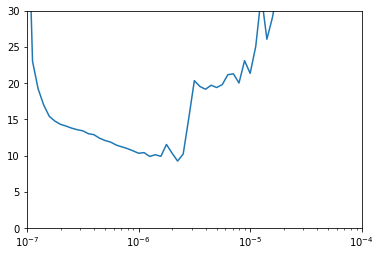

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True
)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 128ms/step - loss: 62.2651 - mae: 62.7634 - val_loss: 53.7722 - val_mae: 54.2722
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
8/8 [==============================] - 0s 57ms/step - loss: 36.4882 - mae: 36.9857 - val_loss: 17.5198 - val_mae: 18.0160
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
8/8 [==============================] - 1s 66ms/step - loss: 22.5146 - mae: 23.0087 - val_loss: 18.8164 - val_mae: 19.3133
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 16.8478 - mae: 17.3388 - val_loss: 20.0787 - val_mae: 20.5773
Epoch 5/500
8/8 [==============================] - 1s 55ms/step - loss: 13.6258 - mae: 14.1148 - val_loss: 6.8458 - val_mae: 7.3288
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 6/500
8/8 [==============================] - 0s 49ms/step - loss: 11.3513 - mae: 11.8347 - val_loss: 7.2709 - val_mae: 7.7557
Epoch 7/500
8/8 [==============

In [9]:
model = keras.models.load_model("my_checkpoint")


In [10]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size
)[:, 0]

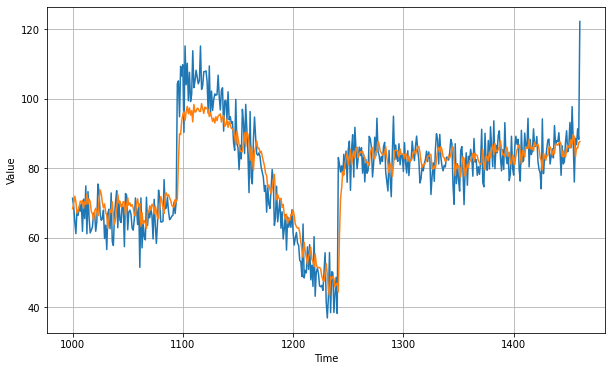

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3282275

## Sequence to Sequence forcasting

In [26]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  # ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))    
  # ds = ds.flat_map(lambda w: w.batch(window_size + 1))  
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [27]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]


In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
        keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(100, return_sequences=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/30)
)
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 2s 46ms/step - loss: 57.8164 - mae: 58.3161
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 24.4222 - mae: 24.9174
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 26.4628 - mae: 26.9590
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 21.9066 - mae: 22.4000
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 19.9172 - mae: 20.4086
Epoch 6/100
8/8 [==============================] - 0s 40ms/step - loss: 18.7127 - mae: 19.2032
Epoch 7/100
8/8 [==============================] - 0s 40ms/step - loss: 18.4775 - mae: 18.9660
Epoch 8/100
8/8 [==============================] - 0s 38ms/step - loss: 18.1116 - mae: 18.6009
Epoch 9/100
8/8 [==============================] - 0s 41ms/step - loss: 17.6015 - mae: 18.0906
Epoch 10/100
8/8 [==============================] - 0s 37ms/step - loss: 16.9587 - mae: 17.4472
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

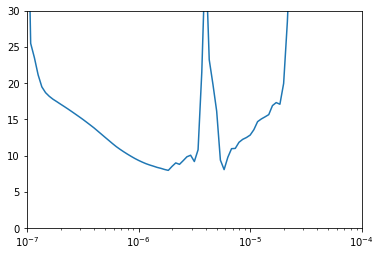

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [36]:
keras.backend.clear_session()
tf.random.set_seed(28)
np.random.seed(28)

window_size=30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200.0)
])

In [43]:
# run_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

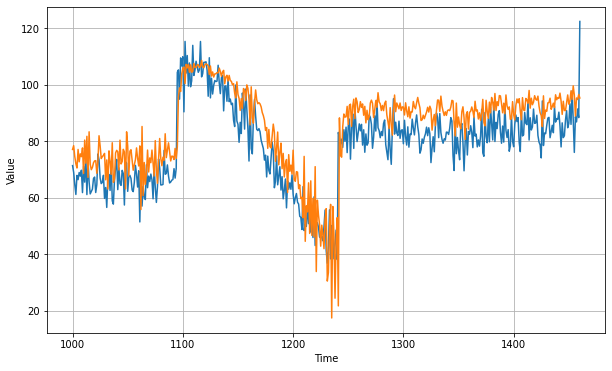

In [44]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [45]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

8.670058